In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, log_loss, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
# Data Preprocessing and Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    '/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    '/kaggle/input/whole-proper-dataset-for-freshness-detection/FRESHNESSDATASET(PROPER)',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 14927 images belonging to 26 classes.
Found 3715 images belonging to 26 classes.


In [3]:
# Load and Customize DenseNet121 Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Add Dropout to prevent overfitting
output = Dense(26, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Load DenseNet121 Model with fewer frozen layers
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [5]:
# Freeze the first 50 layers (instead of 100) to allow learning in later layers
for layer in base_model.layers[:50]:
    layer.trainable = False
for layer in base_model.layers[50:]:
    layer.trainable = True

In [6]:
# Add custom layers
x = Flatten()(base_model.output)
x = BatchNormalization()(x)  # Adding Batch Normalization
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization to the dense layer
x = Dropout(0.4)(x)  # Dropout rate increased to 0.4 to improve regularization
output = Dense(26, activation='softmax')(x)


In [7]:
# Build the final model
model = Model(inputs=base_model.input, outputs=output)


In [8]:
# Compile the model with an increased learning rate for faster learning
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
model_checkpoint = ModelCheckpoint('best_model_dense121.keras', monitor='val_loss', save_best_only=True)

In [10]:
# EarlyStopping and ModelCheckpoint callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_dense121.keras', monitor='val_loss', save_best_only=True)

In [11]:
# Train the model with more epochs
history = model.fit(
    train_data,
    epochs=15,  # Increased epochs to give the model more time to learn
    validation_data=val_data,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729224713.506492      80 service.cc:145] XLA service 0x7e99f4004e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729224713.506579      80 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1729224793.196539      80 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_slice_fusion_2', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1729224793.348707      80 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once fo

 63/467 ━━━━━━━━━━━━━━━━━━━━ 3:46 562ms/step - accuracy: 0.2625 - loss: 11.4489

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


467/467 ━━━━━━━━━━━━━━━━━━━━ 566s 917ms/step - accuracy: 0.3741 - loss: 11.3579 - val_accuracy: 0.3534 - val_loss: 7.7490
Epoch 2/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 249s 528ms/step - accuracy: 0.5831 - loss: 5.5504 - val_accuracy: 0.6310 - val_loss: 4.0370
Epoch 3/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 244s 516ms/step - accuracy: 0.6655 - loss: 3.4906 - val_accuracy: 0.6738 - val_loss: 3.5606
Epoch 4/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 240s 509ms/step - accuracy: 0.7044 - loss: 3.0590 - val_accuracy: 0.6304 - val_loss: 4.4014
Epoch 5/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 242s 513ms/step - accuracy: 0.7226 - loss: 2.9335 - val_accuracy: 0.6425 - val_loss: 4.6858
Epoch 6/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 243s 515ms/step - accuracy: 0.7268 - loss: 2.8054 - val_accuracy: 0.6918 - val_loss: 3.4837
Epoch 7/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 244s 516ms/step - accuracy: 0.7493 - loss: 2.5272 - val_accuracy: 0.6503 - val_loss: 4.1023
Epoch 8/15
467/467 ━━━━━━━━━━━━━━━━━━━━ 245s 519ms/step - accuracy: 0.7564 - loss: 2.7

In [12]:
# Save the trained model
model.save('freshness_detection_model.h5')

In [13]:
# Evaluate Model on Test Data (after training)
test_data = val_data  # Assuming val_data also serves as test data in this example
test_data.reset()
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=-1)

117/117 ━━━━━━━━━━━━━━━━━━━━ 65s 482ms/step


In [14]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test accuracy: {test_accuracy:.2f}')

117/117 ━━━━━━━━━━━━━━━━━━━━ 50s 425ms/step - accuracy: 0.7440 - loss: 2.2207
Test accuracy: 0.75


In [15]:
# Print Test Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {test_accuracy:.4f}")

Accuracy: 0.0460


In [16]:
# Calculate other Evaluation Metrics
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
roc_auc = roc_auc_score(to_categorical(y_true), model.predict(test_data), multi_class='ovr')
log_loss_value = log_loss(to_categorical(y_true), model.predict(test_data))



print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Log Loss: {log_loss_value:.4f}")

 98/117 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 417ms/step
 17/117 ━━━━━━━━━━━━━━━━━━━━ 40s 406ms/step

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


117/117 ━━━━━━━━━━━━━━━━━━━━ 49s 418ms/step
Precision: 0.0431
Recall: 0.0460
F1 Score: 0.0419
ROC AUC: 0.4998
Log Loss: 11.7907


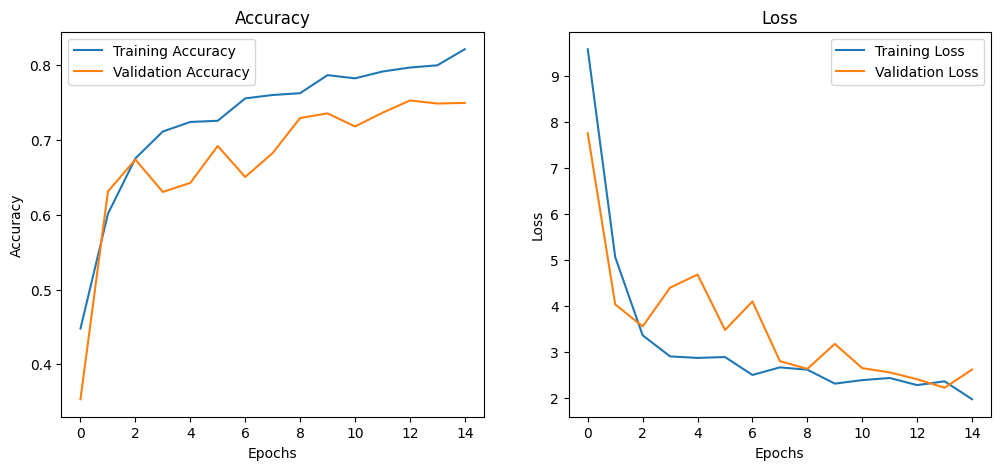

In [17]:

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()